# Импорты

In [1]:
import numpy as np
import pandas as pd

import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Загрузка данных, ознакомление

In [2]:
df = pd.read_csv('IMDB Dataset.csv')

In [3]:
df.shape

(50000, 2)

In [4]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


Незамысловатый датасет - всего два столбца: текст отзыва и его эмоциональная окраска. <br />
Сразу видим, что в текстах содержатся элементы разметки `<br />` - надо будет исключить.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


# Преобразование текстов

In [6]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
stemmer = nltk.stem.snowball.EnglishStemmer('english')

In [7]:
def data_stemmer(text):
    return ' '.join([stemmer.stem(word) for word in text.split(' ') if word not in stop])

In [8]:
df.review = df.review.apply(lambda x: x.lower().replace('<br />',''))

In [9]:
df.review = df.review.apply(lambda x: data_stemmer(x))

Привели все тексты к нижнему регистру, убрали элементы разметки и применили EnglishStemmer.

# Разделение выборок

In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df.sentiment = le.fit_transform(df.sentiment)

In [11]:
X = df.review
y = df.sentiment

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

Закодировали целевую переменную метками классов, разделили выборки на train-test.

# TF-IDF

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_vectorizer = TfidfVectorizer(stop_words=stop, 
                                ngram_range=(1, 2),
                                min_df=2,
                                max_df=0.5,
                                norm=None)

In [14]:
X_train_tfidf = tf_vectorizer.fit_transform(X_train)
X_test_tfidf = tf_vectorizer.transform(X_test)
X_train_tfidf.shape, X_test_tfidf.shape

((35000, 486198), (15000, 486198))

Применили меру tf-idf и получили внушительное признаковое пространство на ~ 500к фич

# Logreg

In [15]:
from sklearn.linear_model import LogisticRegressionCV
logit_cv = LogisticRegressionCV(Cs=10, n_jobs=-1)
logit_cv.fit(X_train_tfidf, y_train)
y_train_pred = logit_cv.predict(X_train_tfidf)
y_test_pred = logit_cv.predict(X_test_tfidf)

In [16]:
print('Accuracy on train set:', accuracy_score(y_train_pred, y_train))
print('Accuracy on test set:', accuracy_score(y_test_pred, y_test))
print(classification_report(y_test_pred, y_test))

Accuracy on train set: 0.9932
Accuracy on test set: 0.9035333333333333
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      7254
           1       0.92      0.90      0.91      7746

    accuracy                           0.90     15000
   macro avg       0.90      0.90      0.90     15000
weighted avg       0.90      0.90      0.90     15000



In [17]:
def plot_confusion(y_pred, y_real, titles):
    cm = confusion_matrix(y_real, y_pred)
    conf_matrix = pd.DataFrame(data = cm, 
                               index = [i for i in titles],
                               columns = [i for i in titles])
    plt.figure(figsize = (5,5))
    sns.heatmap(conf_matrix,
                annot=True,
                fmt='g',
                cbar=False);

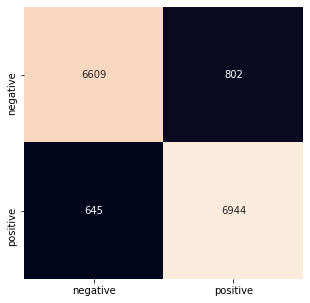

In [18]:
plot_confusion(y_test_pred, y_test, list(set(le.inverse_transform(df.sentiment))))

На полученном признаковом пространстве обучили логистическую регрессию и получили неплохую точность на тесте ~ 90%

# Визуализация признаков

Теперь можно посмотреть на коэффициенты, которые модель раздала нашим terms

In [19]:
def visualize_coefficients(coef, coef_index, feature_names, title, n_features=25):
    
    plt.figure(figsize=(15, 15))
    plt.subplot(512)
    cmap = plt.cm.get_cmap('RdBu')
    norm = Normalize()
    colors = cmap(norm(coef))
    
    plt.bar(np.arange(n_features), coef, color=colors)
    plt.xticks(np.arange(0, n_features), 
               feature_names[coef_index], rotation=60, ha="right", fontsize=14);
    plt.title(title)

In [20]:
n_features = 30
coef = logit_cv.coef_[0]
interest_coef_sort_index = np.argsort(coef)[-n_features:]
interest_coef = coef[interest_coef_sort_index]
uninterest_coef_sort_index = np.argsort(coef)[:n_features]
uninterest_coef = coef[uninterest_coef_sort_index]

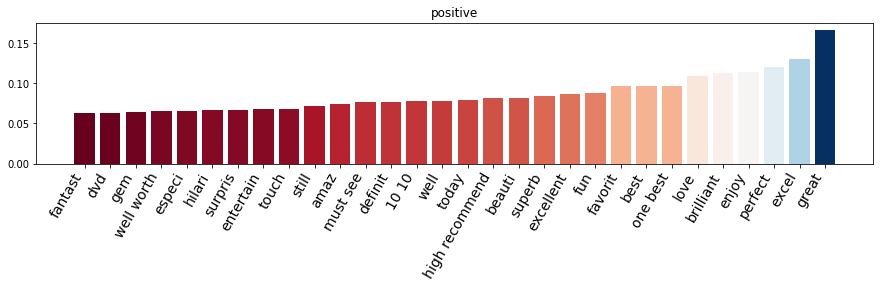

In [23]:
visualize_coefficients(coef=interest_coef,
                       coef_index=interest_coef_sort_index,
                       feature_names=np.array(tf_vectorizer.get_feature_names()), 
                       title=list(set(le.inverse_transform(df.sentiment)))[1],
                       n_features=n_features)

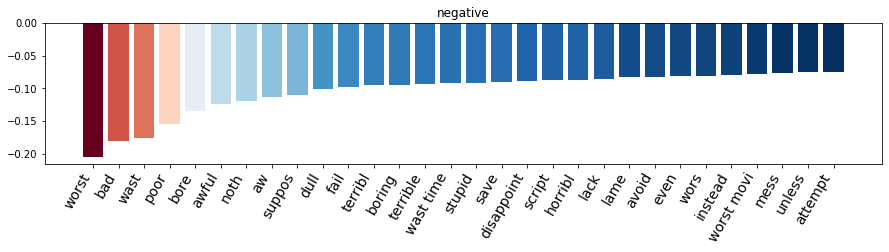

In [24]:
visualize_coefficients(coef=uninterest_coef,
                       coef_index=uninterest_coef_sort_index,
                       feature_names=np.array(tf_vectorizer.get_feature_names()), 
                       title=list(set(le.inverse_transform(df.sentiment)))[0],
                       n_features=n_features)

Ожидаемо, на настроение отзыва синонимы и различные степени слова 'good' (для позитивных комментариев) и слова 'bad' (для негативных комментариев). <br />
Интересно было бы посмотреть на нейтральные отзывы - наиболее объективные, которые скорее всего будут содержать слова из обоих полученных наборов